# Learn the globally optimal proposal for a linear gaussian state space model

We reproduce the experiment in Naesseth and al. Variational SMC

In [21]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2

seaborn.set()


In [22]:
tf.config.set_visible_devices([], 'GPU') 

In [23]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationModel

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.base import ProposalModelBase

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver, NaiveSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

### Set up the model

In [24]:
tf.random.set_seed(0)
rndstate = np.random.RandomState(0)

T = 25

d_x = 10
d_y = 10

alpha = 0.42
gamma = 0.1

B = 1
N = 4

transition_matrix = np.array([[alpha**(abs(i-j) + 1) for j in range(d_x)] for i in range(d_x)], dtype=np.float32)
transition_covariance = np.eye(d_x, dtype=np.float32)


observation_covariance = gamma * np.eye(d_y, dtype=np.float32)
observation_matrix = np.zeros([d_y, d_x], dtype=np.float32)
observation_matrix[:d_y, :d_y] = np.eye(d_y, dtype=np.float32)
# observation_matrix = np.ones([d_y, d_x], dtype=np.float32)
# observation_matrix = np.random.normal(0., 1., [d_y, d_x]).astype(np.float32)


initial_state_mean = np.zeros(d_x, dtype=np.float32)
initial_state_covariance = np.eye(d_x, dtype=np.float32)

kf = pykalman.KalmanFilter(transition_matrix, observation_matrix, transition_covariance, observation_covariance, initial_state_mean=initial_state_mean, initial_state_covariance=initial_state_covariance)
observations = kf.sample(T, random_state=rndstate)[1].data.astype(np.float32)

true_log_likelihood = kf.loglikelihood(observations)
true_log_likelihood

-383.28591316387576

In [25]:
observations_dataset = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filterflow filter

In [26]:
transition_noise = tfd.MultivariateNormalDiag(tf.zeros(d_x, dtype=tf.float32), tf.linalg.diag_part(transition_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
transition_model = RandomWalkModel(tf.convert_to_tensor(transition_matrix), transition_noise)

In [27]:
observation_error = tfd.MultivariateNormalDiag(tf.zeros(d_y, dtype=tf.float32), tf.linalg.diag_part(observation_covariance) ** 0.5) # mind it MultivariateNormalDiag does diag * diag...
observation_model = LinearObservationModel(tf.convert_to_tensor(observation_matrix), observation_error)

In [28]:
class LearnableProposalModel(ProposalModelBase):
    def __init__(self, transition_matrix, name='LearnableProposalModel'):
        super(LearnableProposalModel, self).__init__(name=name)
        self._transition_matrix = transition_matrix
        self._standard_noise = tfd.MultivariateNormalDiag(tf.zeros(transition_matrix.shape[0]), tf.ones(transition_matrix.shape[0]))
    
    def propose(self, state: State, inputs, _observation: tf.Tensor):
        """See base class"""
        mu_t, beta_t, sigma_t = inputs
        
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)        
        proposed_particles = pushed_particles + scaled_rv.sample([state.batch_size, state.n_particles])
        return attr.evolve(state, particles=proposed_particles)

    def loglikelihood(self, proposed_state: State, state: State, inputs: tf.Tensor, observation: tf.Tensor):
        """Interface method for particle proposal
        :param proposed_state: State
            proposed state
        :param state: State
            previous particle filter state
        :param inputs: tf.Tensor
            Control variables (time elapsed, some environment variables, etc)
        :param observation: tf.Tensor
            Look ahead observation for adapted particle proposal
        :return: proposed State
        :rtype: tf.Tensor
        """            
        mu_t, beta_t, sigma_t = inputs
        transition_matrix = tf.linalg.matmul(tf.linalg.diag(beta_t), self._transition_matrix)
        pushed_particles = tf.reshape(mu_t, [1, 1, -1]) + tf.linalg.matvec(transition_matrix, state.particles)
        
        scale = tfp.bijectors.ScaleMatvecDiag(sigma_t)
        scaled_rv = tfd.TransformedDistribution(self._standard_noise, bijector=scale)
        
        diff = (pushed_particles - proposed_state.particles)
        return scaled_rv.log_prob(diff)

In [29]:
proposal_model = LearnableProposalModel(transition_matrix)
bootstrap_proposal = BootstrapProposalModel(transition_model)

In [30]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
resampling_method = MultinomialResampler()

epsilon = tf.constant(0.25)
scaling = tf.constant(0.33)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-1)

solver = PetkovSolver(tf.constant(30))
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)

    
systematic_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)
regularized_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, corrected)
bootstrap_smc = SMC(observation_model, transition_model, bootstrap_proposal, resampling_criterion, resampling_method)

In [31]:
initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([B, N])
uniform_weights = tf.ones([B, N])
uniform_weights = uniform_weights / tf.reduce_sum(uniform_weights, 1, keepdims=True)

uniform_log_weights = tf.math.log(uniform_weights)
log_likelihoods = tf.zeros([B])
init_state = State(initial_particles, uniform_log_weights, uniform_weights, log_likelihoods, None, None)

In [32]:
LARGE_N = 1000
large_initial_particles = tfd.MultivariateNormalDiag(initial_state_mean, tf.linalg.diag_part(initial_state_covariance)**0.5).sample([B, LARGE_N])
large_uniform_weights = tf.ones([B, LARGE_N])
large_uniform_weights = large_uniform_weights / tf.reduce_sum(large_uniform_weights, 1, keepdims=True)

large_uniform_log_weights = tf.math.log(large_uniform_weights)
large_init_state = State(large_initial_particles, large_uniform_log_weights, large_uniform_weights, log_likelihoods, None, None)

### Create the learnable variables that will be used as inputs to the proposal

In [33]:
scale = 0.5

mu_ts_init = scale * tf.random.normal([T, d_x])
beta_ts_init = 1. + scale * tf.random.normal([T, d_x])
log_sigma_ts_init = scale * tf.random.normal([T, d_x])

mu_ts_init = tf.zeros([T, d_x])
beta_ts_init = tf.ones([T, d_x])
log_sigma_ts_init = tf.zeros([T, d_x])


mu_ts = tf.Variable(mu_ts_init, trainable=True)
beta_ts = tf.Variable(beta_ts_init, trainable=True)
log_sigma_ts = tf.Variable(log_sigma_ts_init, trainable=True)

# beta_ts = []
# sigma_ts = []
# for t in range(T):
#     mu_ts.append(tf.Variable(0., trainable=True))
#     beta_ts.append(tf.Variable(1., trainable=True))
#     sigma_ts.append(tf.Variable(gamma, trainable=True))
    


In [34]:
trainable_variables = [mu_ts, beta_ts, log_sigma_ts]

In [35]:
@tf.function
def smc_routine(smc, state, use_correction_term=False):
    iterator = iter(observations_dataset)
    for t in tf.range(T):
        mu_t = mu_ts[t]
        beta_t = beta_ts[t]
        sigma_t = tf.math.exp(log_sigma_ts[t])
        obs = iterator.get_next()
        state = smc.update(state, obs, [mu_t, beta_t, sigma_t])
        t = t + 1
    res = tf.reduce_mean(state.log_likelihoods)
    if use_correction_term:
        return res, tf.reduce_mean(state.resampling_correction)
    return res, tf.constant(0.)
    

In [36]:
test_bootstrap = [smc_routine(bootstrap_smc, init_state)[0].numpy().sum() for _ in range(100)]

In [37]:
np.mean(test_bootstrap)

-2346.311

In [38]:
test_proposal = [smc_routine(systematic_smc, init_state)[0].numpy().sum() for _ in range(100)]

In [39]:
np.mean(test_proposal)

-2279.485

In [40]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2, epsilon=1e-8)

In [41]:
@tf.function
def train_one_step(smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(trainable_variables)
        real_ll, correction = smc_routine(smc, init_state, use_correction_term)
        loss = -(real_ll + correction)
    grads_loss = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads_loss, trainable_variables))
    return real_ll, grads_loss

@tf.function
def train_niter(smc, num_steps=100, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [mu_ts.assign(mu_ts_init), beta_ts.assign(beta_ts_init), log_sigma_ts.assign(log_sigma_ts_init)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        for step in tf.range(1, num_steps+1):
            real_ll, grads = train_one_step(smc, use_correction_term)
            toc = tf.timestamp()
            max_grad = tf.reduce_max(tf.abs(grads))
            if step % (num_steps // 100) == 0:
                tf.print('Step', step, '/', num_steps, ': ms per step= ', 1000. * (toc - tic) / tf.cast(step, tf.float64), ': total time (s)= ', (toc - tic), ', log_likelihood = ', real_ll, ', max abs grads = ', max_grad, end='\r')
            loss_tensor_array = loss_tensor_array.write(step-1, real_ll)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()

@tf.function
def train_total_time(smc, total_time, use_correction_term=False, reset=True):
    if reset:
        reset_operations = [mu_ts.assign(mu_ts_init), beta_ts.assign(beta_ts_init), sigma_ts.assign(sigma_ts_init)]
    else:
        reset_operations = []
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=None, dynamic_size=True, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=None, dynamic_size=True, element_shape=[])
    time_tensor_array = tf.TensorArray(dtype=tf.float64, size=None, dynamic_size=True, element_shape=[])
    with tf.control_dependencies(reset_operations):
        tic = tf.timestamp()
        toc = tic
        step = tf.constant(1)
        while toc - tic < total_time:
            real_ll, grads = train_one_step(smc, use_correction_term)
            toc = tf.timestamp()
            max_grad = tf.reduce_max(tf.abs(grads))
            step = step + 1
            loss_tensor_array = loss_tensor_array.write(step-1, real_ll)
            grad_tensor_array = grad_tensor_array.write(step-1, max_grad)
            time_tensor_array = time_tensor_array.write(step-1, toc-tic)
    return loss_tensor_array.stack(), grad_tensor_array.stack(), time_tensor_array.stack()

In [42]:
tf.print(tf.reduce_mean(log_sigma_ts, 0))
tf.print(tf.reduce_mean(beta_ts, 0))
tf.print(tf.reduce_mean(mu_ts, 0))

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [43]:
true_log_likelihood

-383.28591316387576

In [44]:
n_iter = 1000

In [45]:
sys_ll, _, sys_time = train_niter(systematic_smc, tf.constant(n_iter))

In [47]:
tf.print(tf.reduce_mean(log_sigma_ts, 0))
tf.print(tf.reduce_mean(beta_ts, 0))
tf.print(tf.reduce_mean(mu_ts, 0))

[-1.08926463 -1.02678156 -0.989101231 ... -0.996112466 -1.05066299 -1.13104725]
[0.732885599 0.715748072 0.741765738 ... 0.673267186 0.609014034 0.580585301]
[-0.485406369 -0.20990169 -0.167471468 ... -0.0172053147 0.00615707645 0.306529403]


In [48]:
reg_ll, _, reg_time = train_niter(regularized_smc, tf.constant(n_iter))

In [49]:
tf.print(tf.reduce_mean(log_sigma_ts, 0))
tf.print(tf.reduce_mean(beta_ts, 0))
tf.print(tf.reduce_mean(mu_ts, 0))

[-1.14822578 -1.11412036 -1.090832 ... -1.09202778 -1.12903988 -1.16716874]
[0.677423477 0.607679605 0.66597116 ... 0.617737412 0.529727757 0.528382719]
[-0.516393483 -0.251802266 -0.189569339 ... -0.0337723941 -0.0042978595 0.332090408]


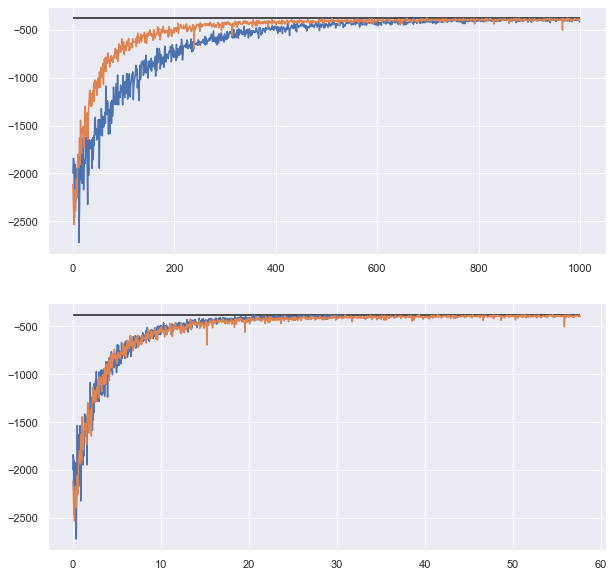

In [51]:
fig, axes = plt.subplots(2, figsize=(10, 10))
axes[0].plot(sys_ll.numpy())
axes[0].plot(reg_ll.numpy())
axes[0].hlines(true_log_likelihood, 0, n_iter)

axes[1].plot(sys_time.numpy(), sys_ll.numpy())
axes[1].plot(reg_time.numpy(), reg_ll.numpy())
axes[1].hlines(true_log_likelihood, 0, reg_time.numpy()[-1])

In [ ]:
tf.reduce_mean(beta_ts, 0)

In [ ]:
tf.reduce_mean(sigma_ts, 0)

In [ ]:
tf.reduce_mean(mu_ts, 0)

In [ ]:
bootstrap_smc(init_state, observations_dataset, T)